# Proyecto 1: Análisis de Datos Pandemia 2020
Este proyecto realiza un análisis de datos utilizando datos recopilados durante la pandemia del 2020. 
Se enfoca en la exploración de datos (EDA), identificación de valores atípicos y análisis multivariado.  

## Importación de librerías necesarias

In [22]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Configuración de conexión a la base de datos

In [23]:
DB_CONNECTION = 'mysql+pymysql://root:@localhost/pandemiaDB'
engine = create_engine(DB_CONNECTION)

## Consulta para obtener datos relevantes

In [24]:
query = '''
SELECT i.fallecidos_municipio AS nuevas_muertes, 
       i.fallecidos_mundiales AS muertes_acumuladas, 
       m.poblacion AS poblacion, 
       m.nombre_municipio, 
       d.nombre_departamento
FROM Integracion_Datos i
JOIN Municipio m ON i.codigo_municipio = m.codigo_municipio
JOIN Departamento d ON m.codigo_departamento = d.codigo_departamento
'''

## Cargar datos desde la base de datos

In [25]:
data = pd.read_sql_query(query, engine)
print("Datos obtenidos de la base de datos:")
print(data.head())

Datos obtenidos de la base de datos:
   nuevas_muertes  muertes_acumuladas  poblacion        nombre_municipio  \
0               1                   0      54623  SAN PEDRO SACATEPEQUEZ   
1               0                   1      54623  SAN PEDRO SACATEPEQUEZ   
2               0                   5      54623  SAN PEDRO SACATEPEQUEZ   
3               0                   5      54623  SAN PEDRO SACATEPEQUEZ   
4               0                   5      54623  SAN PEDRO SACATEPEQUEZ   

  nombre_departamento  
0           GUATEMALA  
1           GUATEMALA  
2           GUATEMALA  
3           GUATEMALA  
4           GUATEMALA  


## EDA Monovariable: Datos Cuantitativos


Estadísticas descriptivas de las variables cuantitativas:
       nuevas_muertes  muertes_acumuladas     poblacion
count    53601.000000        53601.000000  5.360100e+04
mean         0.067387         2322.602340  5.013740e+04
std          0.554739         1633.656262  8.167936e+04
min          0.000000            0.000000  0.000000e+00
25%          0.000000          531.000000  1.746500e+04
50%          0.000000         2611.000000  3.097300e+04
75%          0.000000         3665.000000  5.949600e+04
max         27.000000         4803.000000  1.205668e+06


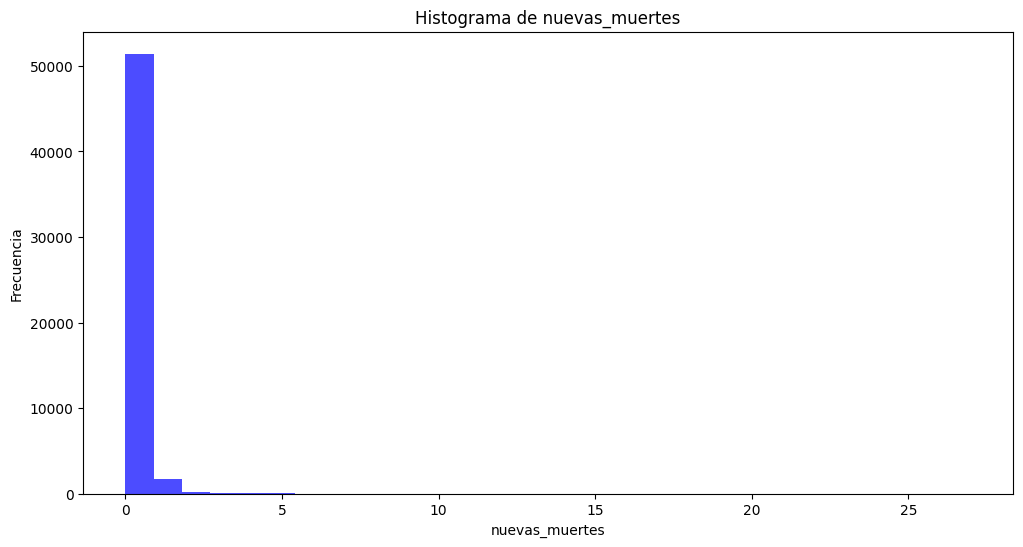

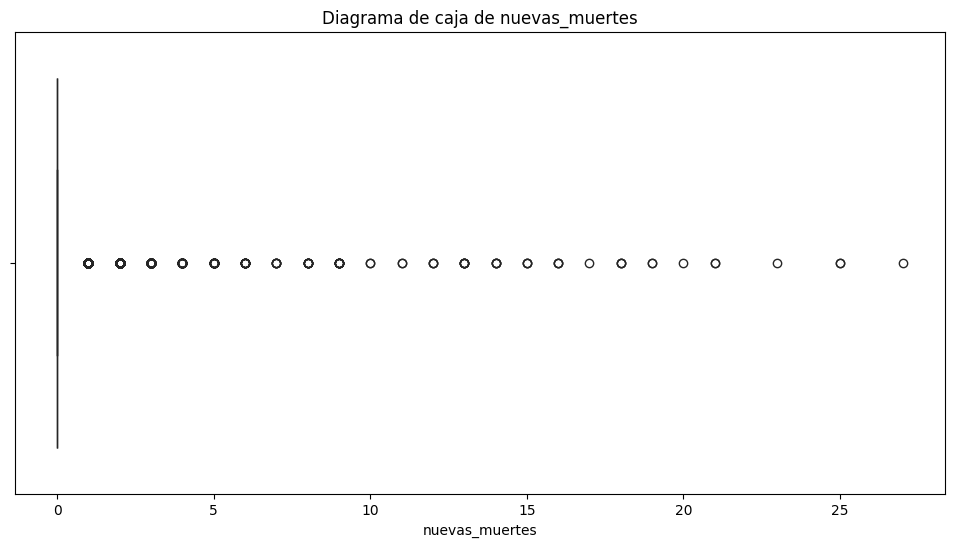

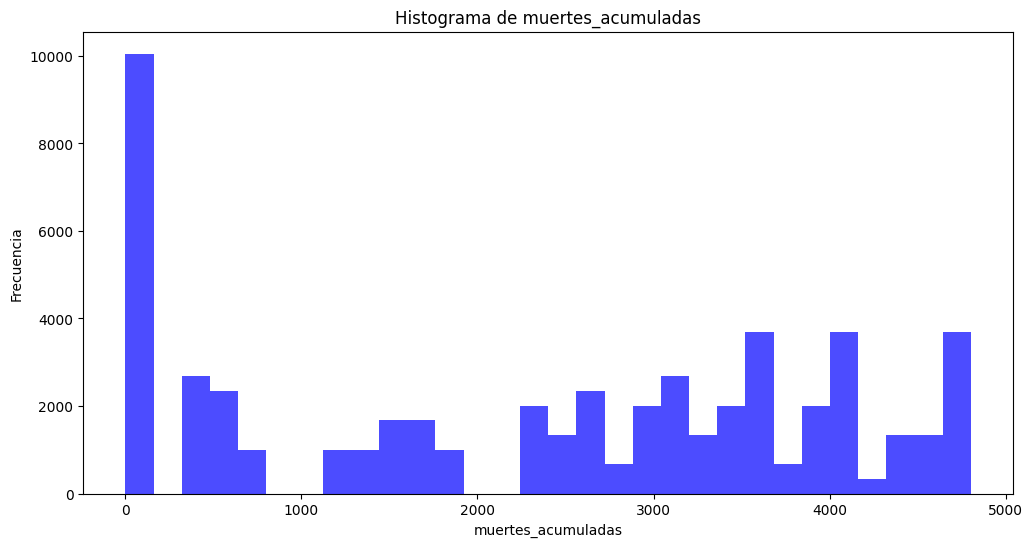

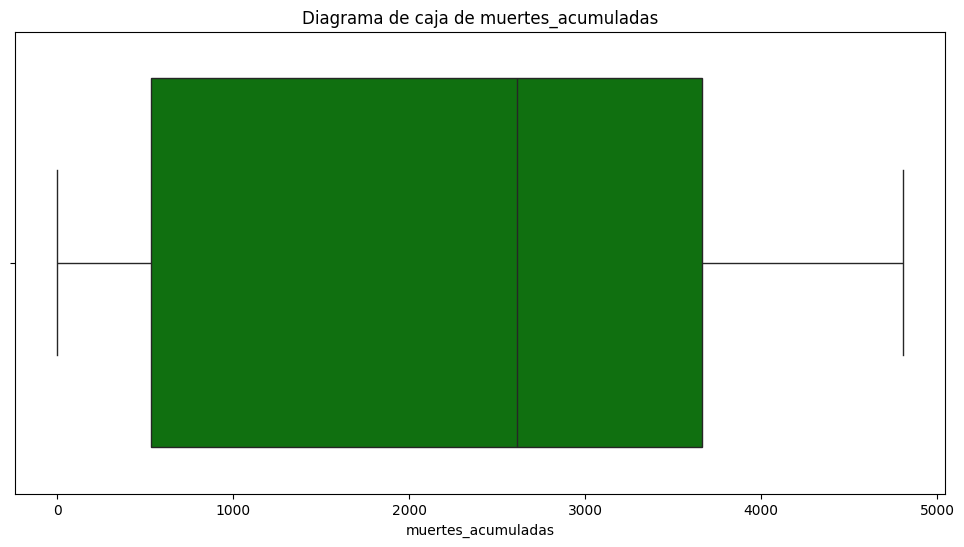

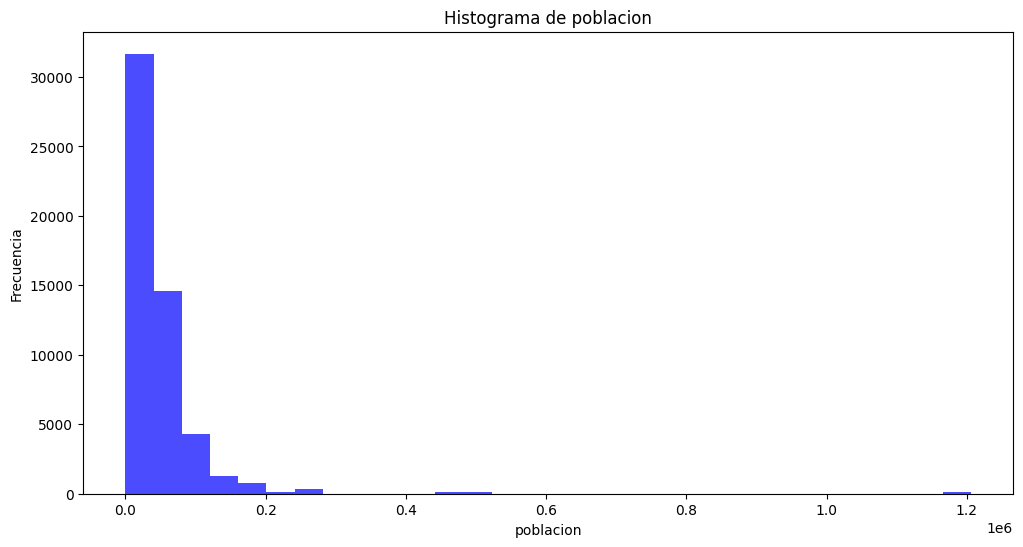

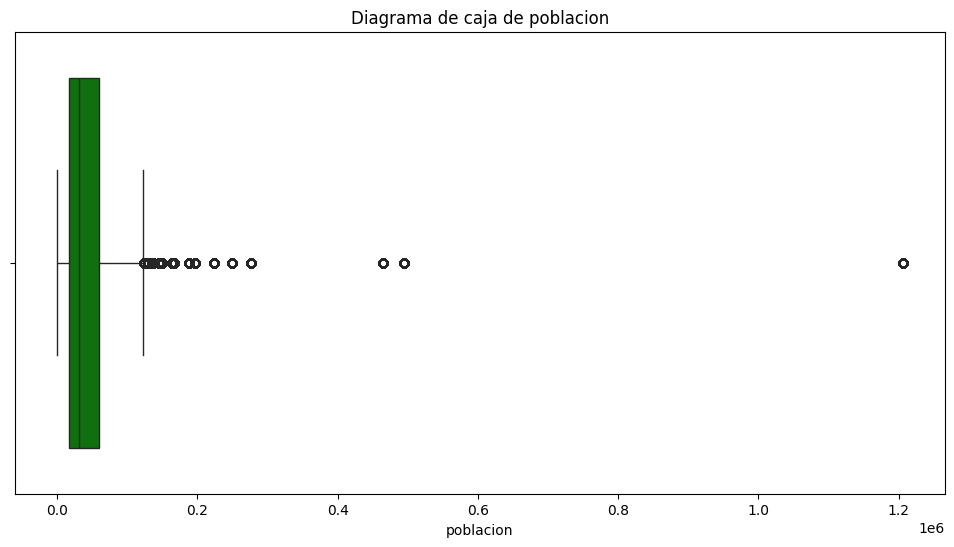

In [26]:
print("\nEstadísticas descriptivas de las variables cuantitativas:")
print(data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].describe())

variables = ['nuevas_muertes', 'muertes_acumuladas', 'poblacion']
for var in variables:
    plt.figure(figsize=(12, 6))
    plt.hist(data[var], bins=30, color='blue', alpha=0.7)
    plt.title(f"Histograma de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=data[var], color='green')
    plt.title(f"Diagrama de caja de {var}")
    plt.xlabel(var)
    plt.show()

### Observaciones de variables cuantitativas
- **Método utilizado**: Histogramas y diagramas de caja generados con **Matplotlib** y **Seaborn**  para explorar la distribución y variabilidad de las variables cuantitativas.
- **Nuevas muertes:** La mayoría de los municipios presentan valores cercanos a 0, pero existen municipios específicos que destacan como focos con niveles significativamente altos de mortalidad, lo que podría indicar eventos críticos o brotes localizados.
- **Muertes acumuladas:** La alta dispersión observada sugiere grandes diferencias en la evolución de la pandemia, reflejando posibles desigualdades en acceso a recursos o efectividad de políticas de contención.
- **Población:** Las distribuciones reflejan que los municipios más grandes presentan mayor variabilidad en las características de sus datos, mientras que los municipios más pequeños tienden a ser más homogéneos.

## EDA Monovariable: Datos Cualitativos

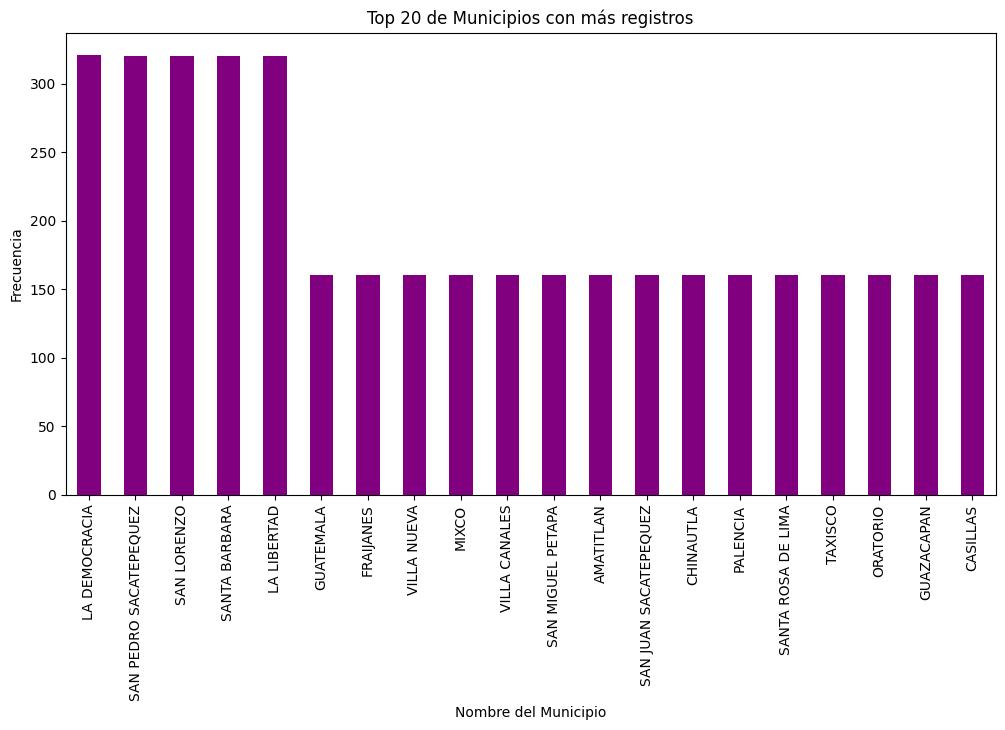

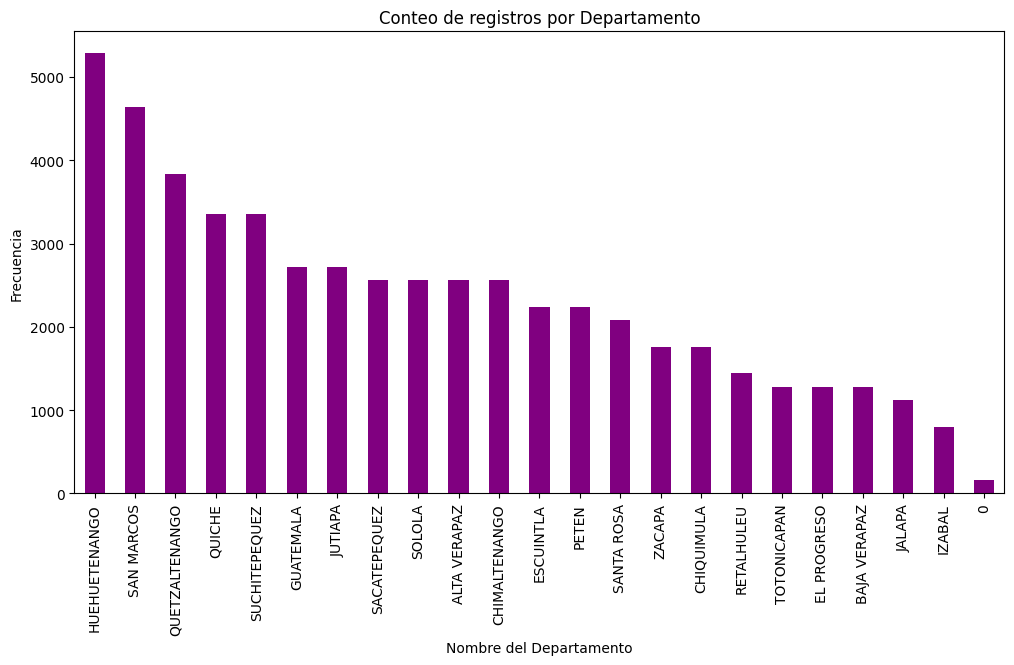

In [27]:
# Mostrar el top 20 de municipios
top_20_municipios = data['nombre_municipio'].value_counts().head(20)
plt.figure(figsize=(12, 6))
top_20_municipios.plot(kind='bar', color='purple')
plt.title("Top 20 de Municipios con más registros")
plt.xlabel("Nombre del Municipio")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.show()

# Mostrar todos los departamentos
plt.figure(figsize=(12, 6))
data['nombre_departamento'].value_counts().plot(kind='bar', color='purple')
plt.title("Conteo de registros por Departamento")
plt.xlabel("Nombre del Departamento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.show()

### Observaciones de variables cualitativas
- **Método utilizado**: Gráficos de barras generados con **Matplotlib** para analizar frecuencias.
- **Nombre municipio:** Los municipios en el top 20 muestran una representación desproporcionada, lo que podría estar vinculado a factores como densidad poblacional, centralización de reportes o capacidad de medición.
- **Nombre departamento:** Los departamentos con mayor representación coinciden con áreas urbanas densamente pobladas como Guatemala y Escuintla, lo que podría reflejar tanto una mayor incidencia de la pandemia como una mejor infraestructura de registro.

## Identificación de outliers con rango intercuartílico (IQR)


Outliers en nuevas_muertes: 2186 encontrados
Aplicando transformación logarítmica a nuevas_muertes debido a sesgo o outliers.


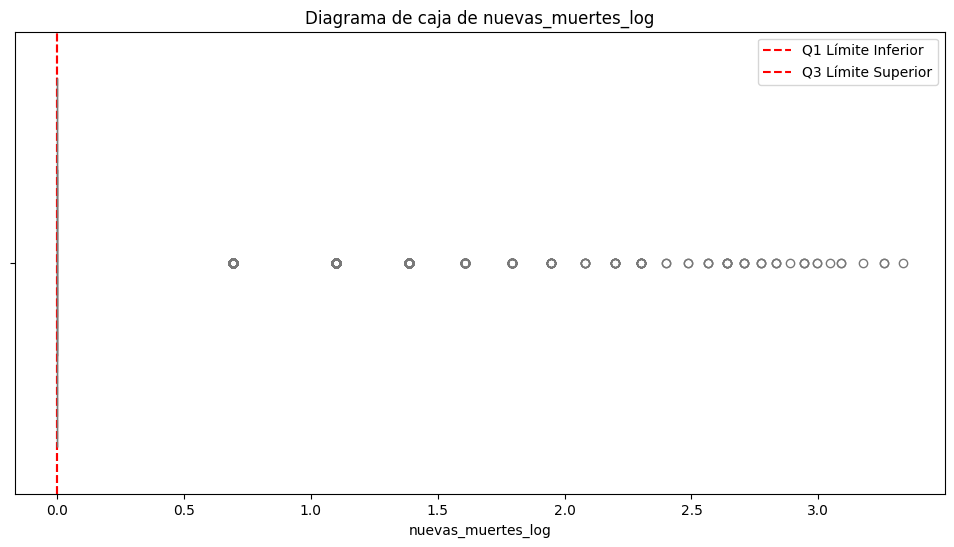


Outliers en muertes_acumuladas: 0 encontrados
No es necesaria ninguna transformación para muertes_acumuladas.


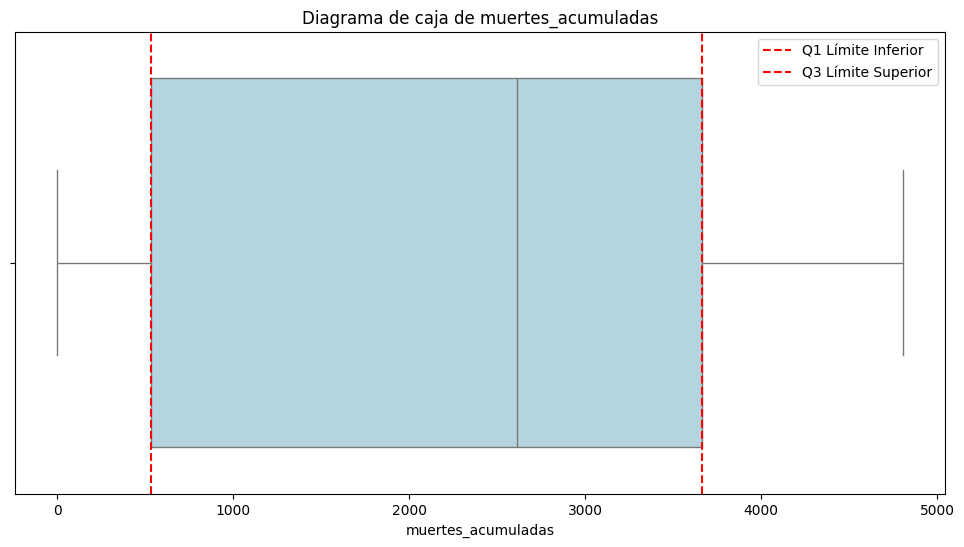


Outliers en poblacion: 2720 encontrados
Aplicando transformación logarítmica a poblacion debido a sesgo o outliers.


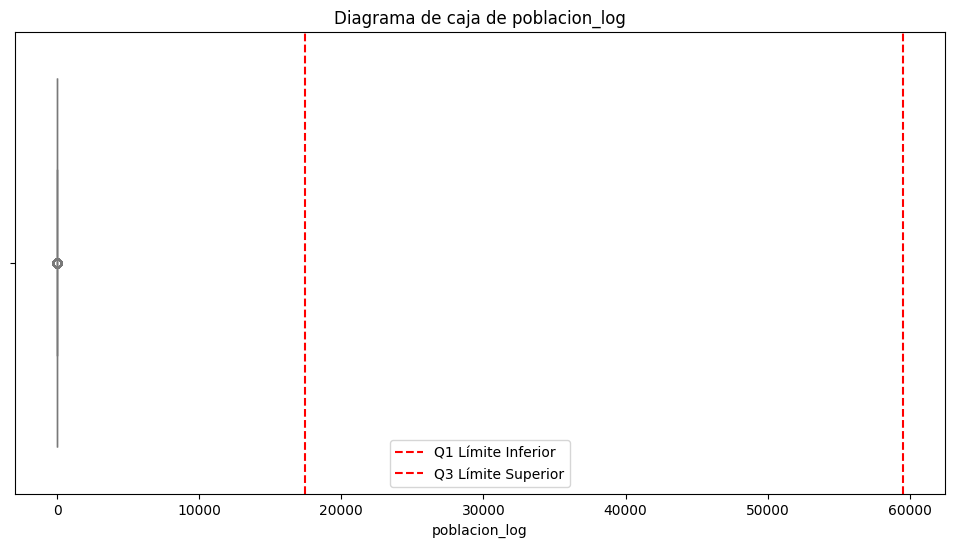

In [28]:
# Variables cuantitativas
variables = ['nuevas_muertes', 'muertes_acumuladas', 'poblacion']

for var in variables:
    # Cálculo de Q1, Q3 y IQR
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificación de outliers
    outliers = data[(data[var] < lower_bound) | (data[var] > upper_bound)]
    print(f"\nOutliers en {var}: {len(outliers)} encontrados")

    # Verificar si la variable tiene sesgo o escala incorrecta
    if len(outliers) > 0 or data[var].skew() > 1:
        print(f"Aplicando transformación logarítmica a {var} debido a sesgo o outliers.")
        data[f'{var}_log'] = np.log1p(data[var])  # Logarítmica para reducir sesgo
        transformed_var = f'{var}_log'
    else:
        print(f"No es necesaria ninguna transformación para {var}.")
        transformed_var = var

    # Gráfico de boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=data[transformed_var], color='lightblue')
    plt.axvline(Q1, color='red', linestyle='--', label='Q1 Límite Inferior')
    plt.axvline(Q3, color='red', linestyle='--', label='Q3 Límite Superior')
    plt.title(f"Diagrama de caja de {transformed_var}")
    plt.xlabel(transformed_var)
    plt.legend()
    plt.show()

## EDA Multivariable: Gráficas de dispersión

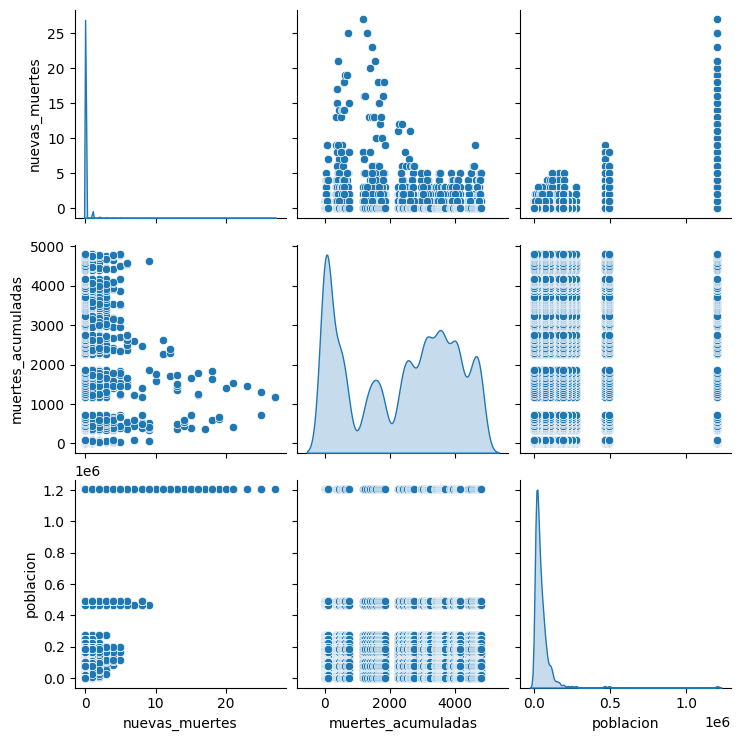

In [29]:
sns.pairplot(data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']], diag_kind='kde')
plt.show()

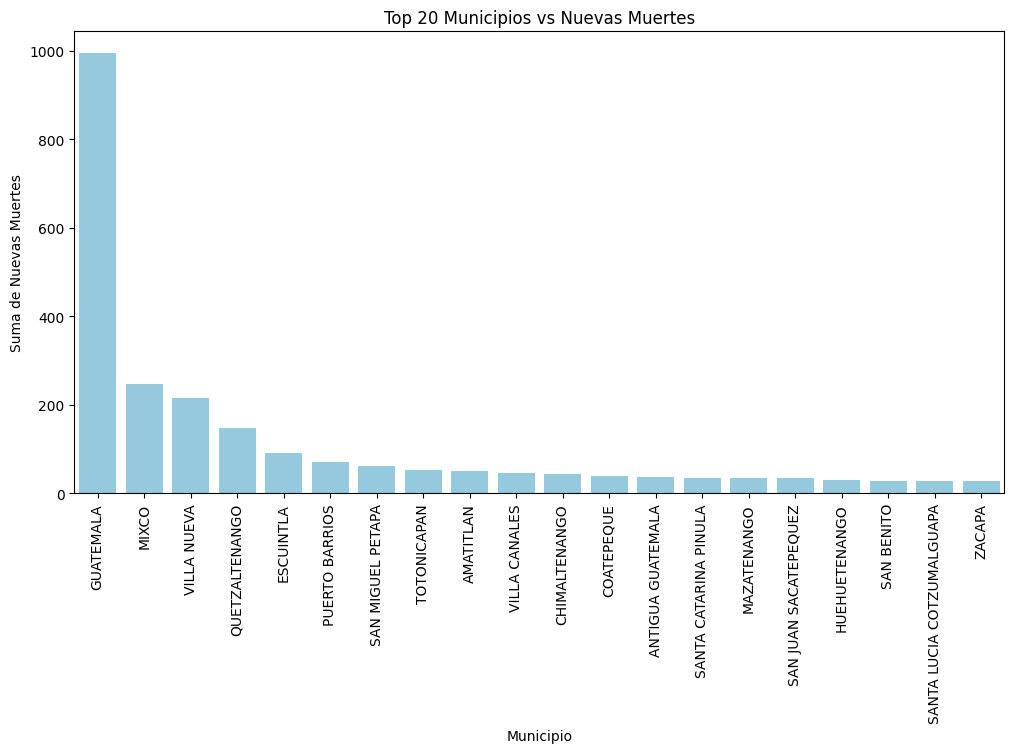

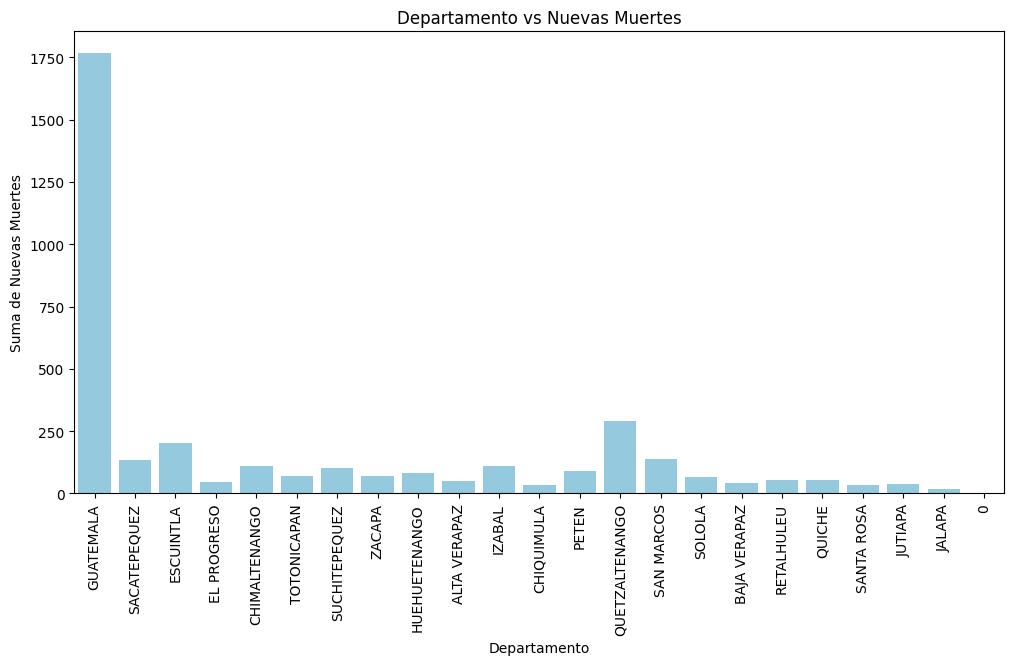

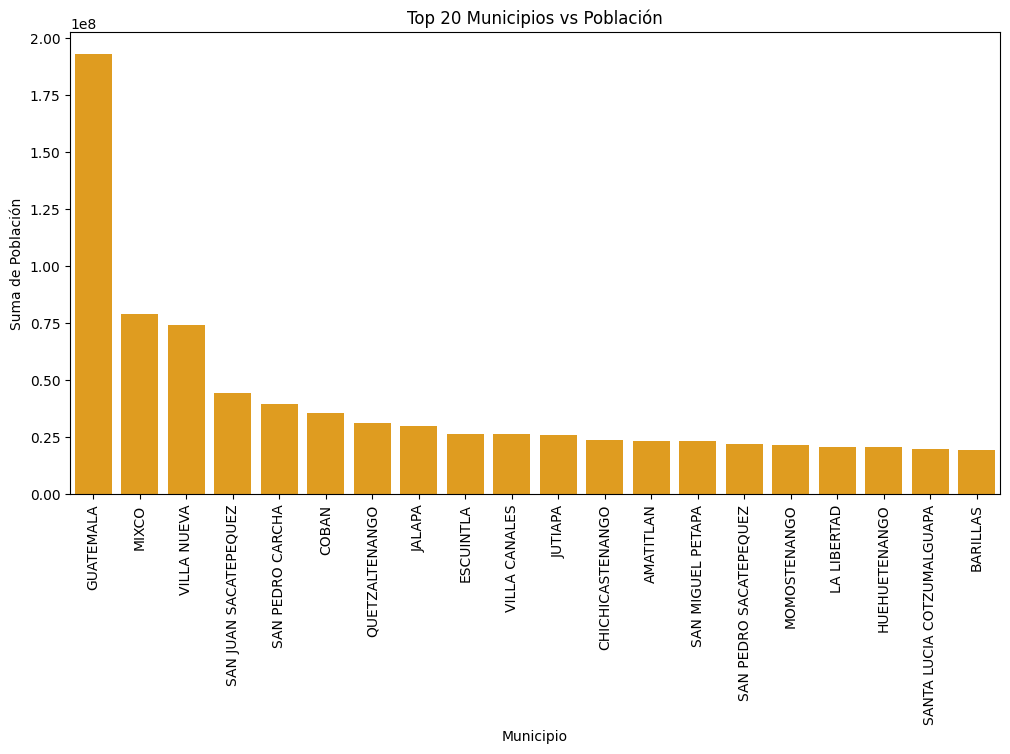

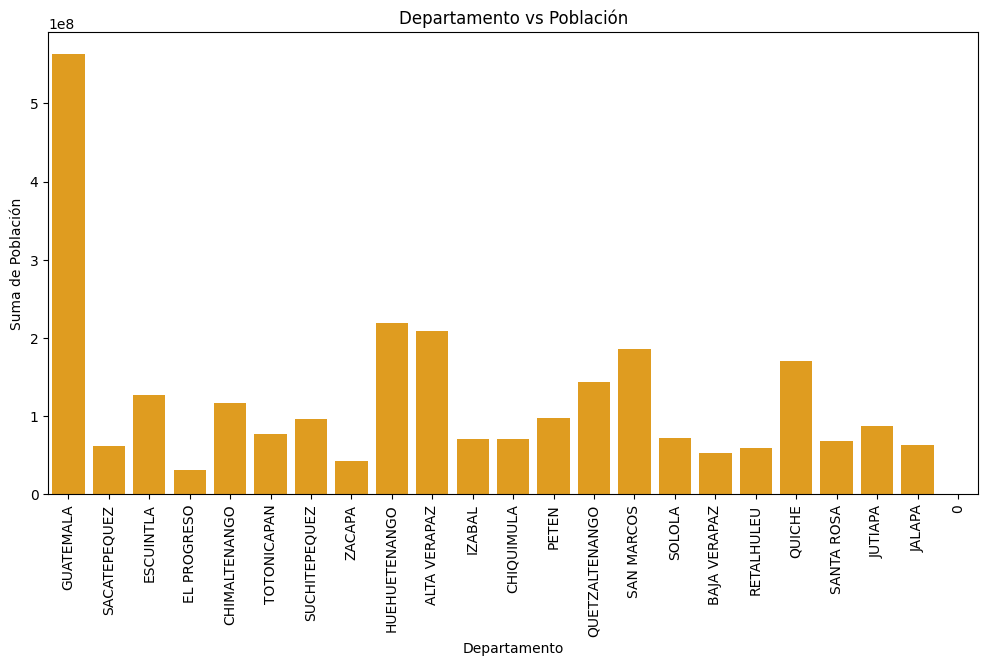

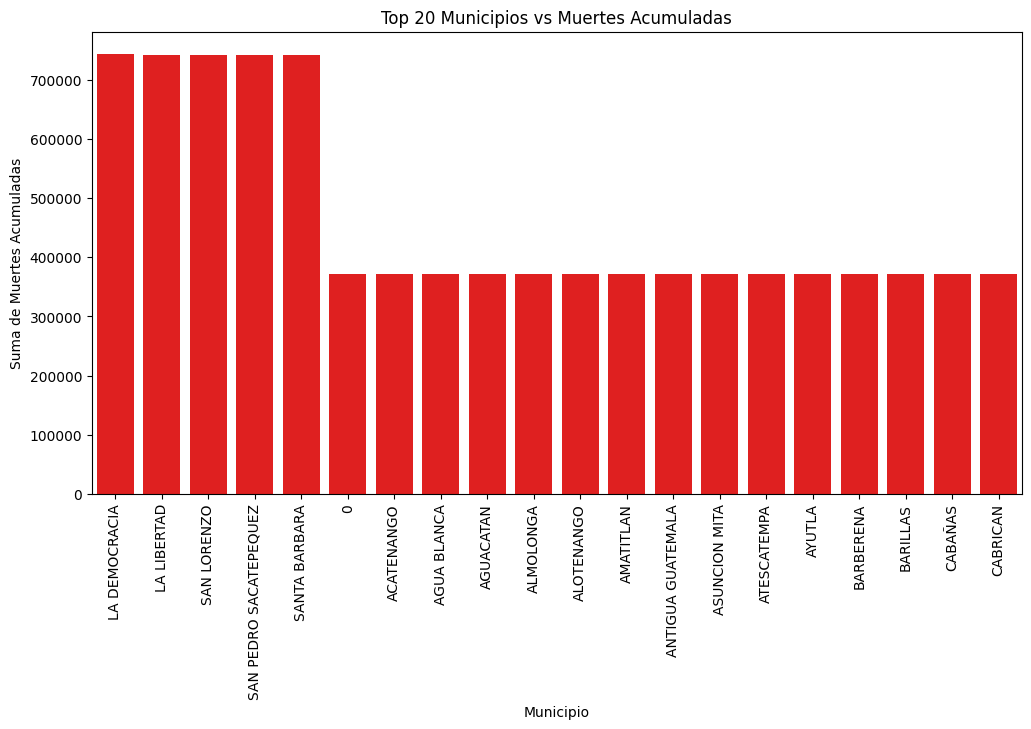

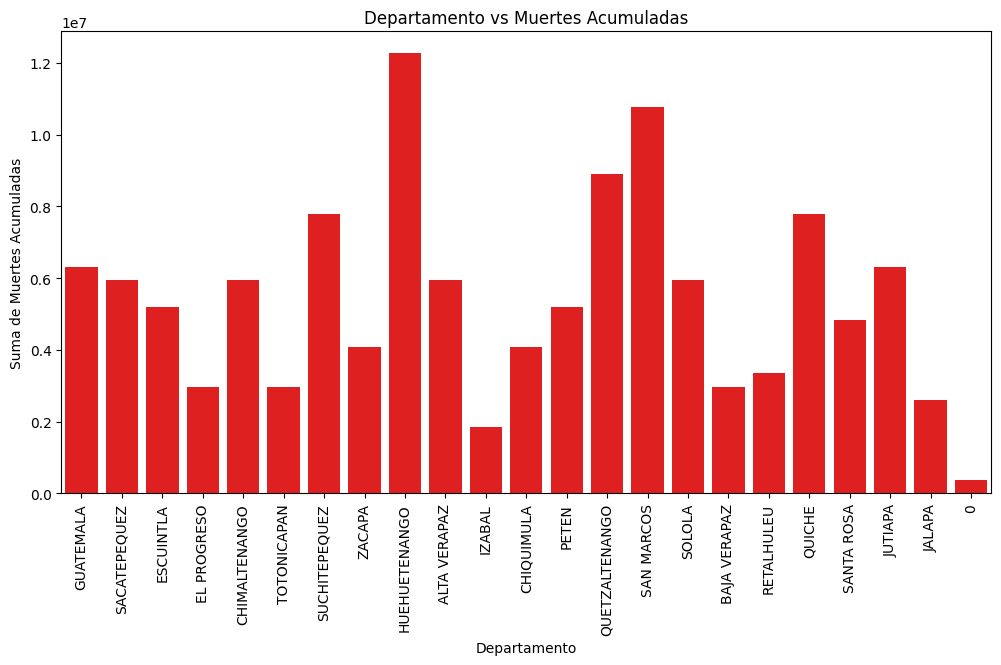

In [30]:
# Municipio vs Nuevas Muertes (Top 20)
top_20_municipios = data.groupby('nombre_municipio')['nuevas_muertes'].sum().nlargest(20).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_municipios['nombre_municipio'], y=top_20_municipios['nuevas_muertes'], errorbar=None, color='skyblue')
plt.title("Top 20 Municipios vs Nuevas Muertes")
plt.xlabel("Municipio")
plt.ylabel("Suma de Nuevas Muertes")
plt.xticks(rotation=90)
plt.show()

# Departamento vs Nuevas Muertes
plt.figure(figsize=(12, 6))
sns.barplot(x=data['nombre_departamento'], y=data['nuevas_muertes'], errorbar=None, color='skyblue', estimator=sum)
plt.title("Departamento vs Nuevas Muertes")
plt.xlabel("Departamento")
plt.ylabel("Suma de Nuevas Muertes")
plt.xticks(rotation=90)
plt.show()

# Municipio vs Población
top_20_municipios = data.groupby('nombre_municipio')['poblacion'].sum().nlargest(20).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_municipios['nombre_municipio'], y=top_20_municipios['poblacion'], errorbar=None, color='orange')
plt.title("Top 20 Municipios vs Población")
plt.xlabel("Municipio")
plt.ylabel("Suma de Población")
plt.xticks(rotation=90)
plt.show()

# Departamento vs Población
plt.figure(figsize=(12, 6))
sns.barplot(x=data['nombre_departamento'], y=data['poblacion'], errorbar=None, color='orange', estimator=sum)
plt.title("Departamento vs Población")
plt.xlabel("Departamento")
plt.ylabel("Suma de Población")
plt.xticks(rotation=90)
plt.show()

# Municipios vs Muertes Acumuladas
top_20_municipios = data.groupby('nombre_municipio')['muertes_acumuladas'].sum().nlargest(20).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_municipios['nombre_municipio'], y=top_20_municipios['muertes_acumuladas'], errorbar=None, color='red')
plt.title("Top 20 Municipios vs Muertes Acumuladas")
plt.xlabel("Municipio")
plt.ylabel("Suma de Muertes Acumuladas")
plt.xticks(rotation=90)
plt.show()

# Departamento vs Muertes Acumuladas
plt.figure(figsize=(12, 6))
sns.barplot(x=data['nombre_departamento'], y=data['muertes_acumuladas'], errorbar=None, color='red', estimator=sum)
plt.title("Departamento vs Muertes Acumuladas")
plt.xlabel("Departamento")
plt.ylabel("Suma de Muertes Acumuladas")
plt.xticks(rotation=90)
plt.show()

### Observaciones de variables cuantitativas multivariables
- **Método utilizado**: Gráficas de dispersión generadas con **Seaborn** para analizar correlaciones entre variables.
- **Población vs Muertes acumuladas:** La correlación positiva significativa indica que municipios con mayor población tienen mayores tasas de mortalidad acumulada, probablemente debido a mayor exposición o congestión.
- **Muertes acumuladas vs Nuevas muertes:** La falta de correspondencia directa sugiere que algunos municipios experimentaron olas o picos en momentos diferentes, lo que amerita una revisión temporal detallada.

## Comparación cualitativos vs cuantitativos

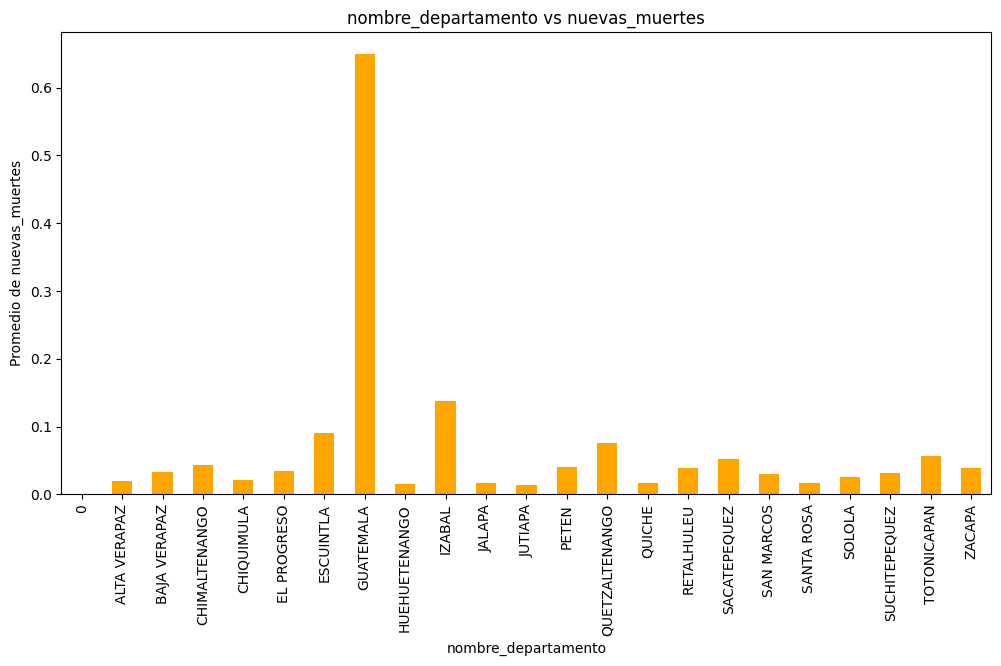

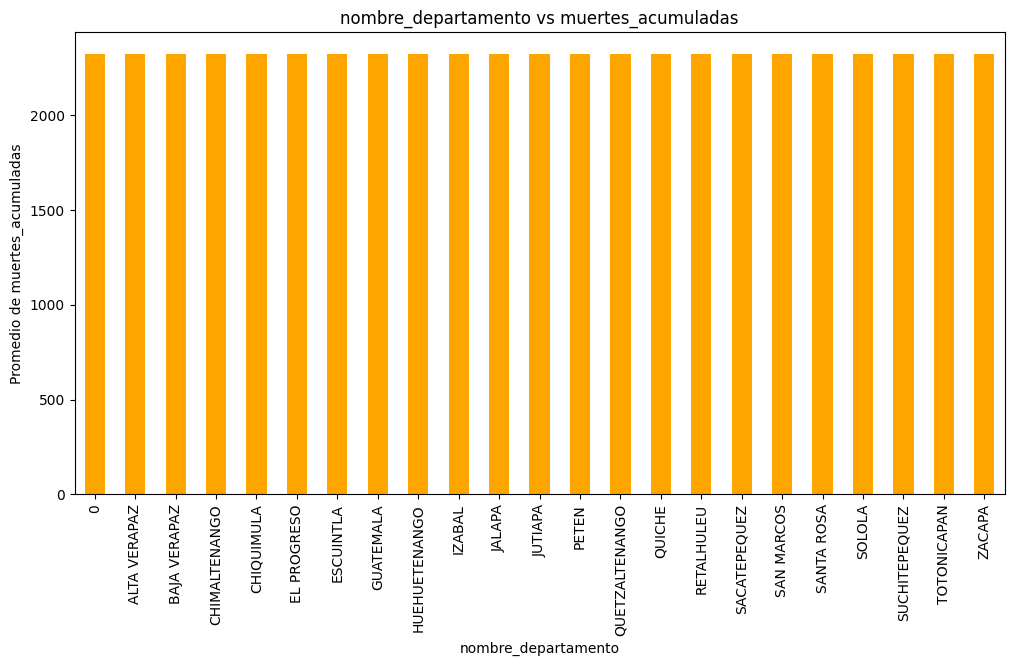

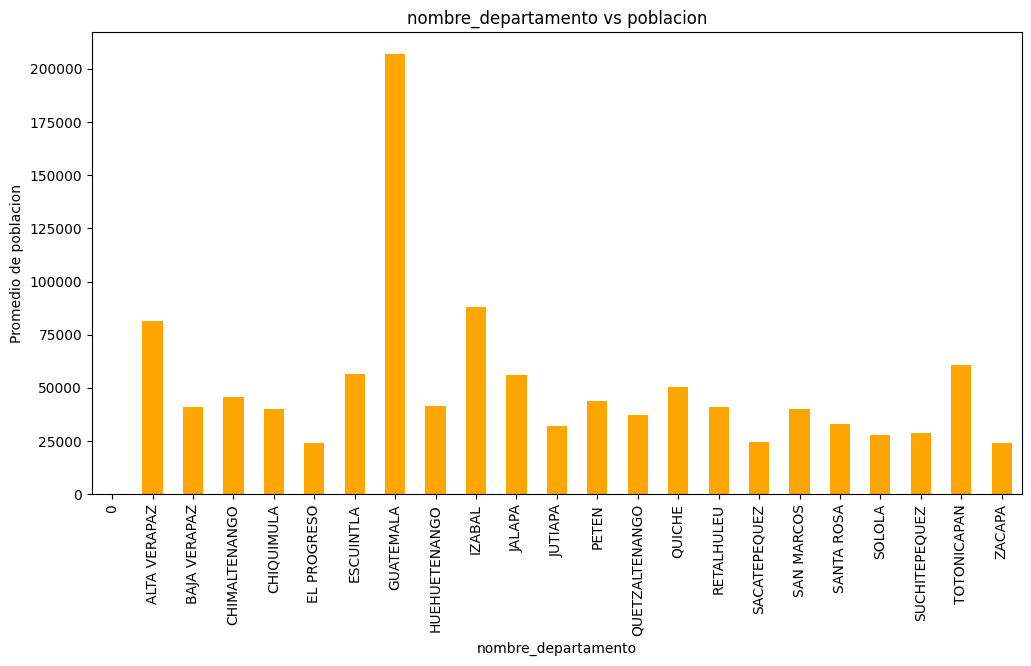

In [31]:
categorias_cuantitativas = ['nuevas_muertes', 'muertes_acumuladas', 'poblacion']
categorias_cualitativas = ['nombre_departamento']

for cual in categorias_cualitativas:
    for cuant in categorias_cuantitativas:
        plt.figure(figsize=(12, 6))
        data.groupby(cual)[cuant].mean().plot(kind='bar', color='orange')
        plt.title(f"{cual} vs {cuant}")
        plt.xlabel(cual)
        plt.ylabel(f"Promedio de {cuant}")
        plt.xticks(rotation=90)
        plt.show()

### Observaciones de variables cualitativas multivariables
- **Método utilizado**: Gráficos de barras generados con **Matplotlib** para comparar promedios de categorías cualitativas con métricas cuantitativas.
- **Nombre departamento vs Muertes acumuladas:**  Departamentos con mayor población, como Guatemala y Escuintla, muestran promedios más altos de mortalidad acumulada, lo que resalta desigualdades en la distribución de casos y fallecimientos.

## Análisis de Correlaciones Pearson, Spearman y Kendall)

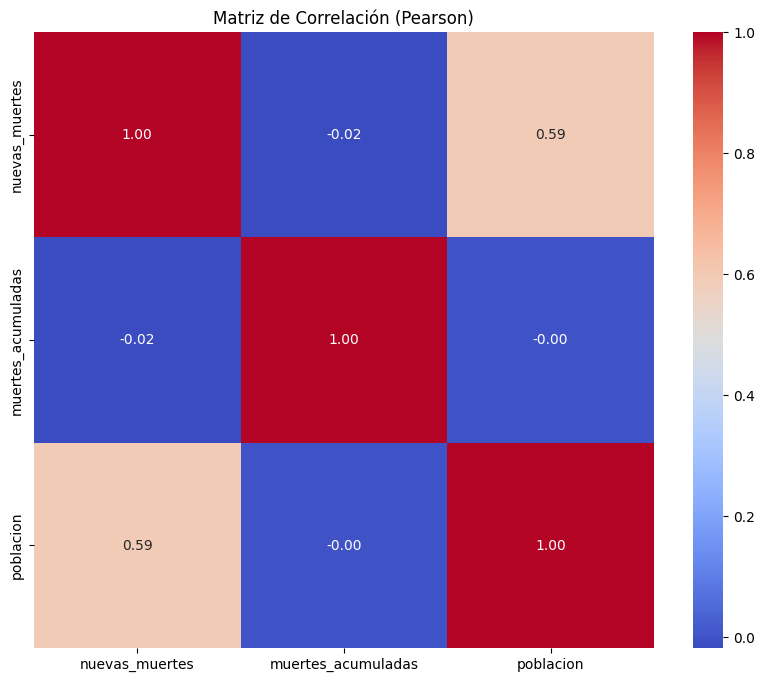

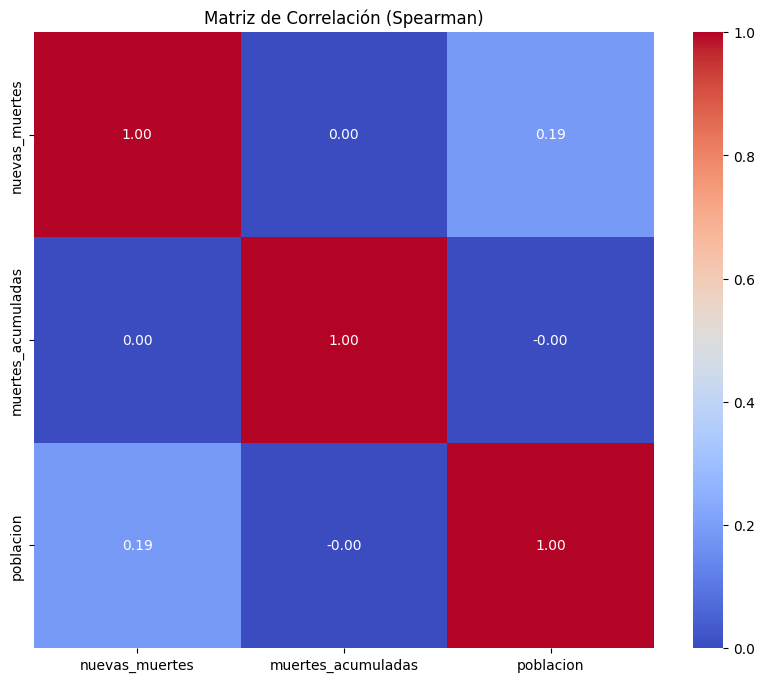

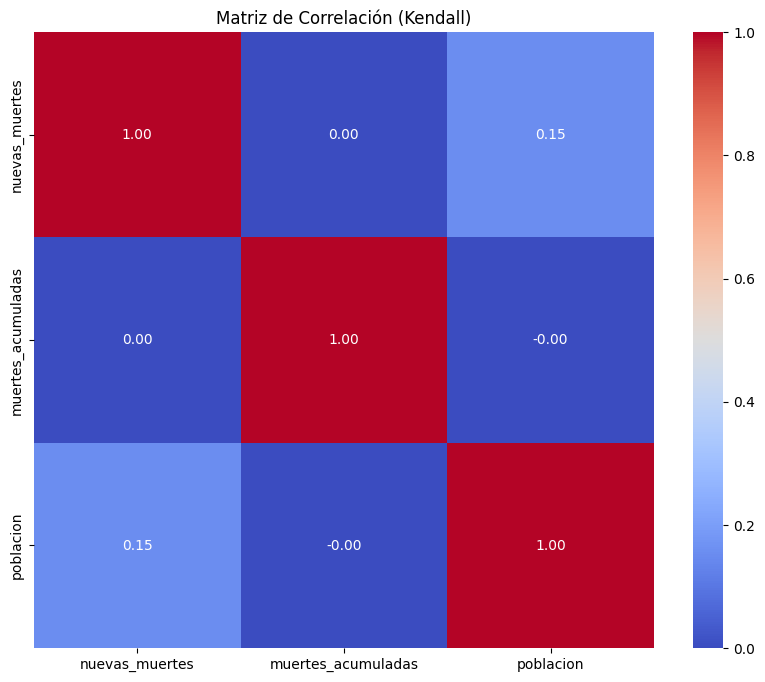

In [32]:
# Matriz de correlación de Pearson
pearson_corr = data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación (Pearson)")
plt.show()

# Matriz de correlación de Spearman
spearman_corr = data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación (Spearman)")
plt.show()

# Coeficiente de correlación de Kendall
kendall_corr = data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación (Kendall)")
plt.show()

## Análisis Gráfico del Test de Chi-cuadrado

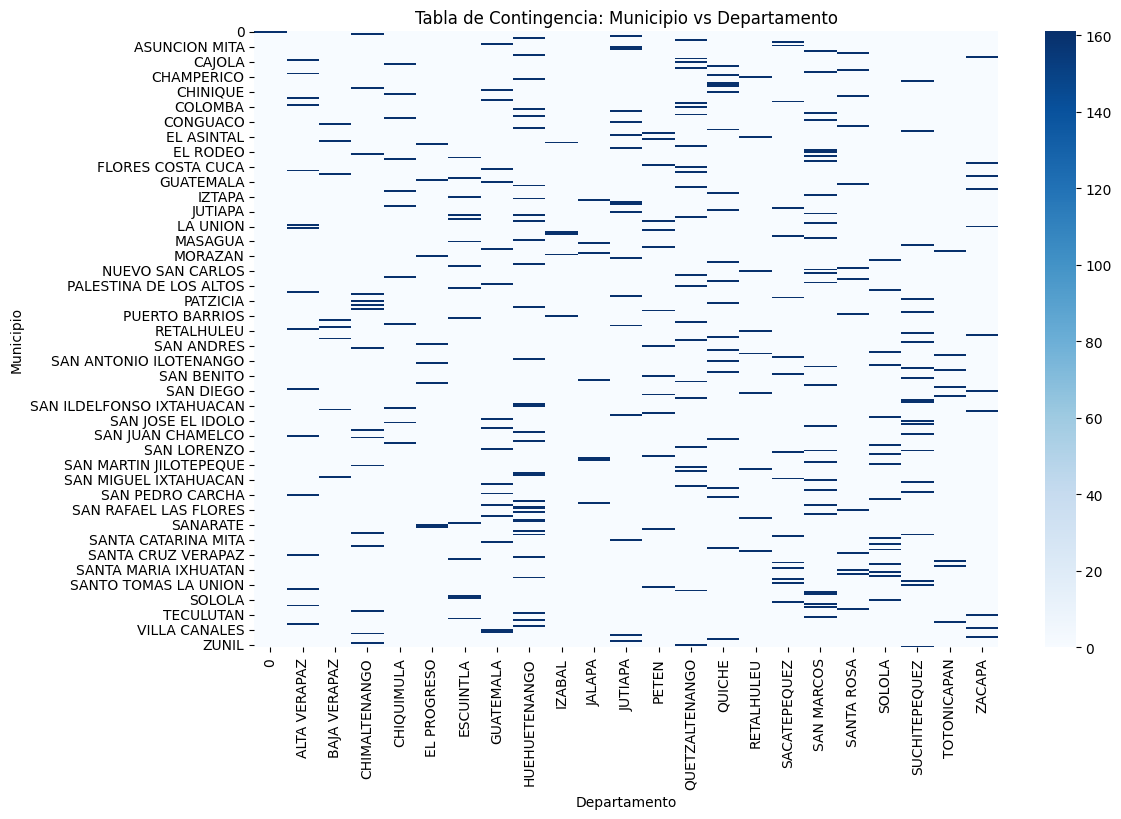


Interpretación del Test de Chi-cuadrado:
Chi2: 1166971.677330528, p-valor: 0.0
Existe una asociación estadísticamente significativa entre Municipio y Departamento.


In [33]:
# Visualizar los datos de contingencia para el análisis gráfico
contingency_table = pd.crosstab(data['nombre_municipio'], data['nombre_departamento'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, cmap='Blues', annot=False, cbar=True)
plt.title("Tabla de Contingencia: Municipio vs Departamento")
plt.xlabel("Departamento")
plt.ylabel("Municipio")
plt.show()

# Interpretación de resultados
print("\nInterpretación del Test de Chi-cuadrado:")
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-valor: {p}")
if p < 0.05:
    print("Existe una asociación estadísticamente significativa entre Municipio y Departamento.")
else:
    print("No existe una asociación estadísticamente significativa entre Municipio y Departamento.")

## Análisis de Multicolinealidad

In [34]:
# Seleccionar las variables independientes
X = data[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].copy()
# Agregar una columna de intercepto
X['intercept'] = 1
# Crear el DataFrame para almacenar el resultado del VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
X = X.drop(columns=['intercept'])

print("Análisis de Multicolinealidad (VIF):")
print(vif_data)

Análisis de Multicolinealidad (VIF):
             Variable       VIF
0      nuevas_muertes  1.539112
1  muertes_acumuladas  1.000489
2           poblacion  1.538623
3           intercept  3.470139


## Mapas de Calor para Variables Cualitativas vs Cuantitativas

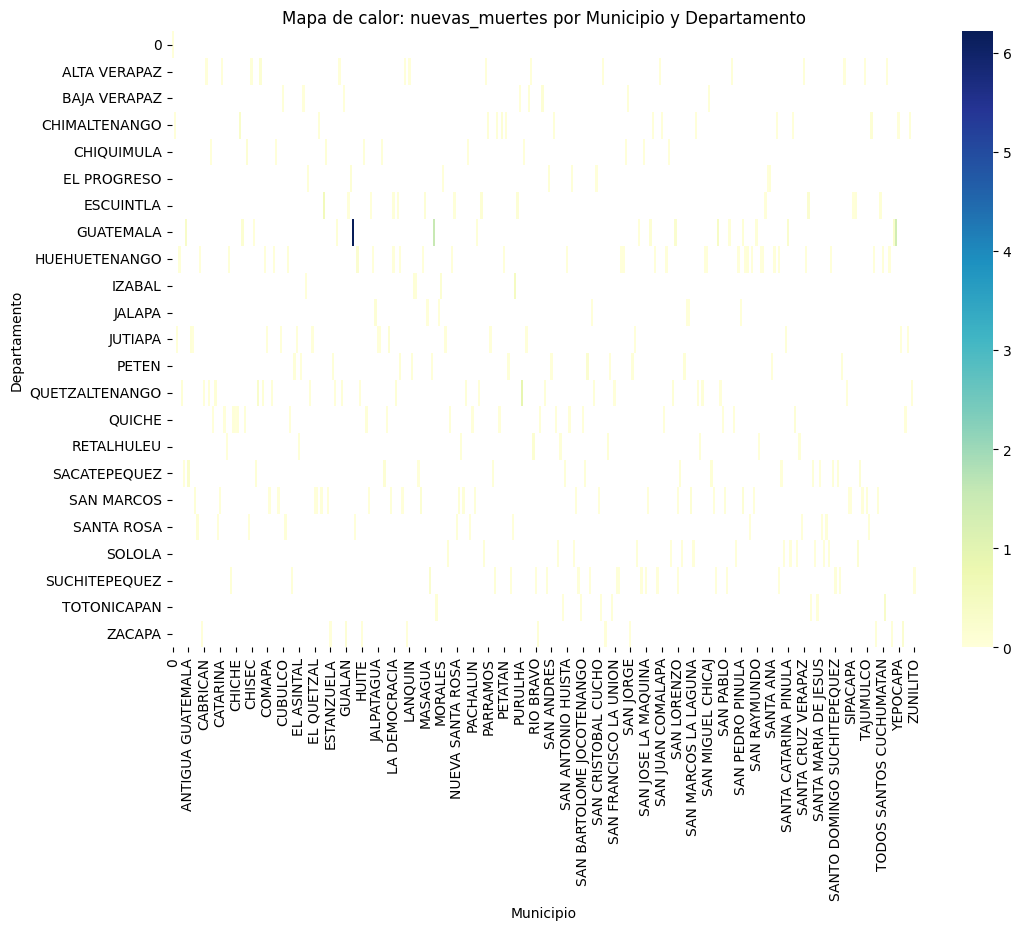

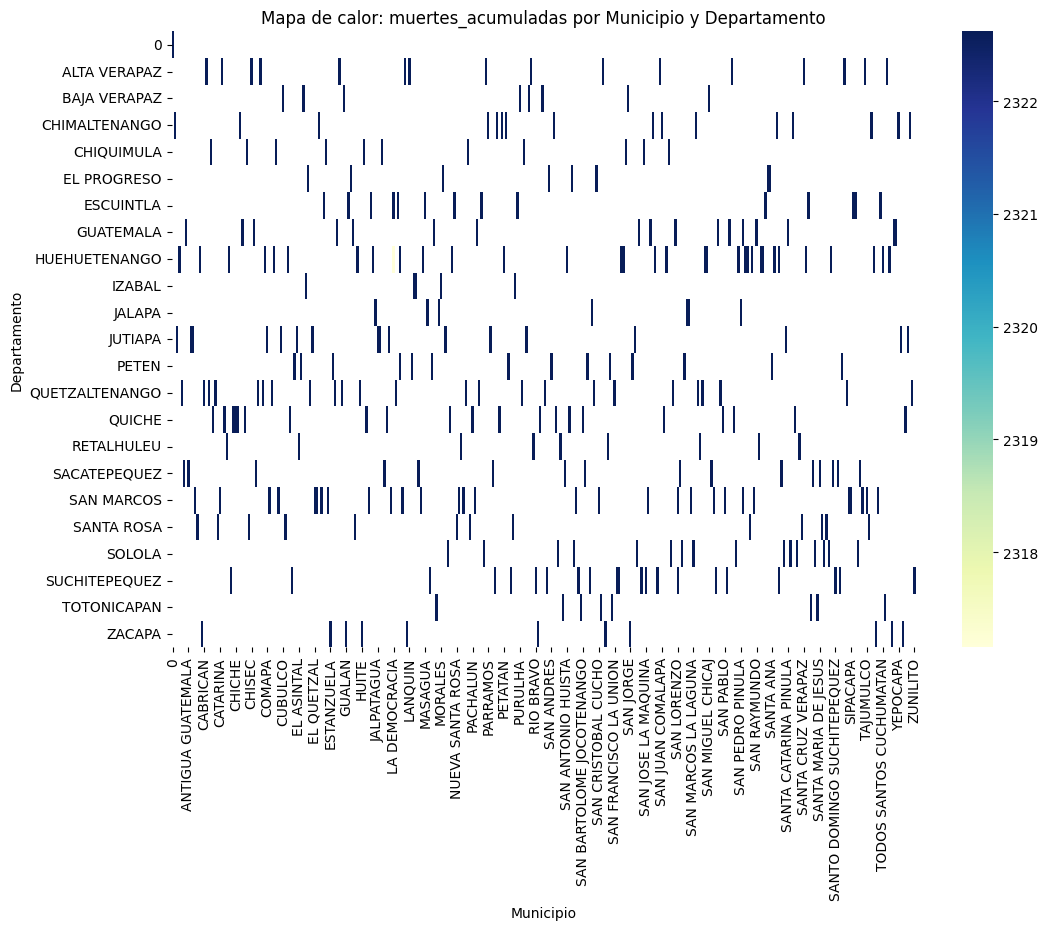

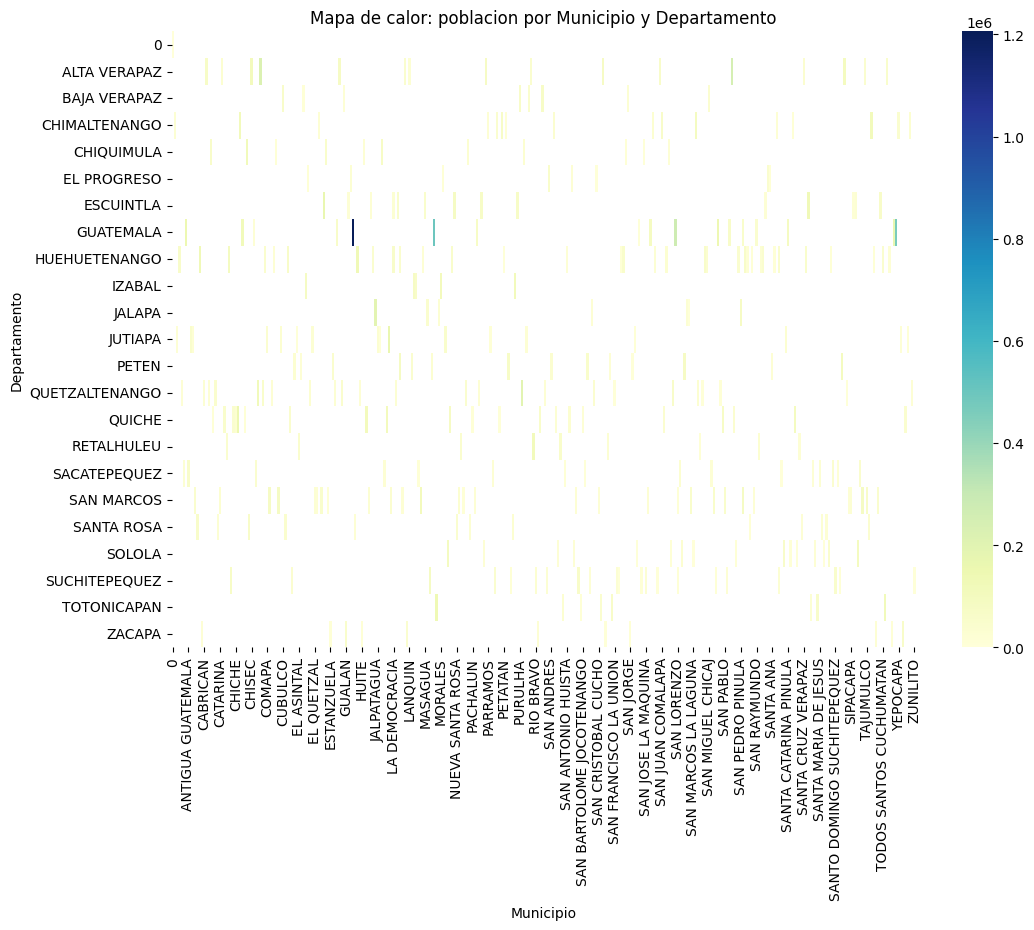

In [35]:
for cuant in categorias_cuantitativas:
    plt.figure(figsize=(12, 8))
    heatmap_data = data.pivot_table(values=cuant, index='nombre_departamento', columns='nombre_municipio', aggfunc='mean')
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
    plt.title(f"Mapa de calor: {cuant} por Municipio y Departamento")
    plt.xlabel("Municipio")
    plt.ylabel("Departamento")
    plt.xticks(rotation=90)
    plt.show()

## Conclusiones Detalladas

### Conclusiones Actualizadas
1. **Disparidades Regionales:** Las áreas urbanas densamente pobladas como Guatemala y Escuintla presentan tasas más altas de mortalidad acumulada. Esto refleja desigualdades regionales en acceso a recursos médicos y políticas de contención.
2. **Focos de Atención:** Los outliers identificados en los histogramas y diagramas de caja destacan municipios que requieren atención prioritaria debido a eventos críticos o brotes localizados.
3. **Impacto del Tamaño Poblacional:** El análisis de correlación muestra una relación fuerte entre la población y las muertes acumuladas, lo que sugiere que los municipios más grandes deben ser priorizados en la asignación de recursos.
4. **Multicolinealidad Baja:** Los resultados del análisis de multicolinealidad (VIF) muestran que las variables clave tienen niveles aceptables de independencia, asegurando la validez de los modelos estadísticos utilizados.
5. **Asociaciones entre Variables Categóricas:** El test de Chi-cuadrado confirma una asociación significativa entre municipio y departamento, lo que implica que los patrones de mortalidad están influidos por características específicas de cada región.